# PRINCIPAL COMPONENT ANALYSIS

In the first part of this notebook one can find implementations on pca, naive pca, iterative pca and probabilistic pca.

After that, several mock up datasets are created to test the implementations.

Finally, the methods are tested with a real dataset with missing values.

In [1]:
import numpy as np
from scipy.linalg import orth, svd

def pca_(X, r, W=None, it=1):
    "Classical PCA using SVD"

    X = X - X.mean(0)
    
    V, L, U = svd(X)
    
    F = np.matmul(V[:, :r], np.diag(L[:r]))
    
    return F, U[:r].T

def naive_pca(X, r, W, it=10):
    "Naive PCA"
    X = X - X.mean(0)
    F_ = np.zeros((X.shape[0], r))
    U_ = np.random.random((X.shape[1], r))
    N, M = X.shape
    
    for k in range(it):
        F_ = np.zeros((X.shape[0], r))
        for n in range(N):
            sum1 = np.zeros((U_.shape[1], U_.shape[1]))
            sum2 = np.zeros((U_.shape[1]))
            for m in range(M):
                sum1 += W[n,m] * (U_[m].reshape(1, -1).T @ U_[m].reshape(1, -1))
                sum2 += W[n,m] * X[n,m] * U_[m]
            F_[n] = sum2 @ np.linalg.pinv(sum1)
        
        U_ = np.zeros((X.shape[1], r))
        for m in range(M):
            sum1 = np.zeros((F_.shape[1], F_.shape[1]))
            sum2 = np.zeros((F_.shape[1]))
            for n in range(N):
                sum1 += W[n,m] * (F_[n].reshape(1, -1).T @ F_[n].reshape(1, -1))
                sum2 += W[n,m] * X[n,m] * F_[n]
            U_[m] = sum2 @ np.linalg.pinv(sum1)
        
        it+=1

    V, S, Vh = svd(U_.T @ U_)

    diag = np.diag([1 / np.sqrt(s) for s in S])
    P = V * diag
    U_ = U_ @ P
    F_ = np.matmul(F_, np.linalg.pinv(P).T)
    
    return F_, U_

def iterative_pca(X, r, W, it=10):
    "Iterative PCA"
    X = X - X.mean(0)    
    U_ = np.random.random((X.shape[1], r))
    X[W == 0] = 0
    
    for i in range(it):
        F_, U_ = pca_(X, r)
        X[W==0] = (F_ @ U_.T)[W==0]
    
    V, S, Vh = svd(U_.T @ U_)

    diag = np.diag([1 / np.sqrt(s) for s in S])
    P = V @ diag
    U_ = U_ @ P
    F_ = np.matmul(F_, np.linalg.pinv(P).T)
    
    return F_, U_    

In [2]:
def ppca(X, K, W, it=10):
    """
    Probabilistic PCA
    Uses a factorizing distribution over hidden states and hidden observations, based on https://github.com/shergreen/pyppca
    """
    N, M = np.shape(X) # N observations in M dimensions (i.e. D is number of features, N is samples)

    X = X - X.mean(0)

    X[W==0] = 0
    
    n_miss = np.sum(W[W==0])

    #initialize
    C = np.random.normal(loc=0.0, scale=1.0, size=(M,K))
    CtC = C.T @ C
    F = (X @ C) @ np.linalg.inv(CtC)
    recon = F @ C.T
    recon[W==0] = 0
    ss = np.sum((recon-X)**2) / (N*M - n_miss)

    count = 0

    #EM Iterations
    while count<it:
        Sx = np.linalg.inv(np.eye(K) + CtC/ss) # E-step, covariances
        ss_old = ss
        if n_miss:
            proj = F @ C.T
            X[W==0] = proj[W==0]
        
        F = X @ C @ Sx / ss # E-step: expected values

        FtF = F.T @ F #M-step
        C = X.T @ F @ (FtF + N*Sx).T @ np.linalg.inv((FtF + N*Sx) @ (FtF + N*Sx).T)
        CtC = C.T @ C
        ss = (np.sum((F @ C.T - X)**2) + N*np.sum(CtC*Sx) + n_miss*ss_old) / (N*M)
        #transform Sx determinant into numpy float128 in order to deal with high dimensionality
        Sx_det = np.min(Sx).astype(np.longdouble)**np.shape(Sx)[0] * np.linalg.det(Sx / np.min(Sx))       
        count+=1
        
    C = orth(C)
    covM = np.cov((X @ C).T)
    vals, vecs = np.linalg.eig(covM)
    ordr = np.argsort(vals)[::-1]
    vecs = vecs[:, ordr]

    C = C @ vecs
    F = X @ C
    return F, C

In [3]:
from scipy.linalg import subspace_angles, norm

import time
def random_comparison(K, method=pca_, W=None, it=1, SNR=None):
    "Function to compare random data using a chosen method"
    if isinstance(K, int):
        F = np.random.random((N, K))
        U = orth(np.random.random((M, K)))
        X = np.matmul(F, U.T)
        X_centered = X - X.mean(0)
        if SNR is not None:
            B = np.random.normal(0, norm(X)**2/(SNR*N*M), (N, M))
            print("Used SNR: ", norm(X)/norm(B))
            X += B
        t = time.time()
        F1, U1 = method(X, K, W, it)
        elapsed = time.time() - t
        error = norm(X_centered - np.matmul(F1,U1.T))**2/(M*N)
        return subspace_angles(F.T, F1.T)[0], subspace_angles(U, U1)[0], error, elapsed
    else:
        _comparison = []
        for k in K:    
            F = np.random.random((N, k))
            U = orth(np.random.random((M, k)))
            X = np.matmul(F, U.T)
            mean = X.mean(0)
            X_centered = X - mean
            if SNR is not None:
                B = np.random.normal(0, norm(X)**2/(SNR*N*M), (N, M))
                # print("Used SNR: ", (norm(X)**2)/(norm(B)**2))
                X += B
            t = time.time()
            F1, U1 = method(X, k, W, it)
            elapsed = time.time() - t
            error = norm(X_centered - np.matmul(F1, U1.T))**2/(M*N)
            _comparison += [[subspace_angles(F.T, F1.T)[0], subspace_angles(U, U1)[0], error, elapsed]]
        return np.array(_comparison, dtype=object)

In [4]:
# N variables, M samples
N, M = 1000, 10
k_values = np.arange(2, M+1)

## 1.1.1 Exact PCA

In [5]:
compPCA = random_comparison(k_values, pca_)

In [11]:
compNaive = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=20)

In [8]:
compIterative = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=100)

In [9]:
compPPCA = random_comparison(k_values, ppca, W=np.ones((N, M)), it=1000)

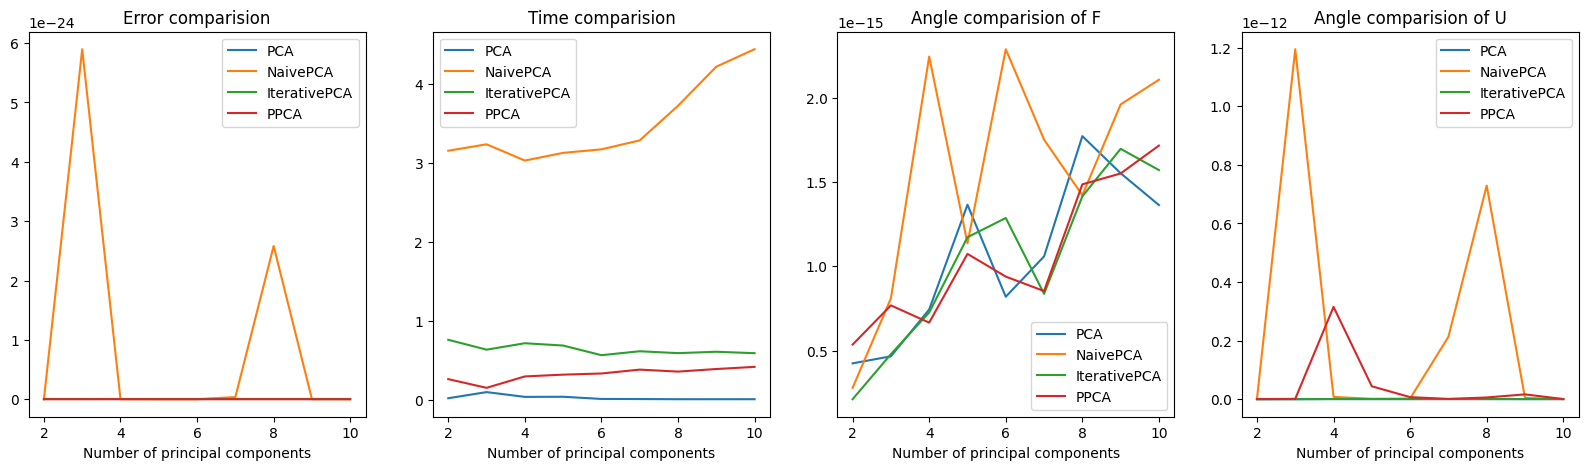

In [12]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot(k_values, compPCA[:, 2], label='PCA')
ax[0].plot(k_values, compNaive[:, 2], label='NaivePCA')
ax[0].plot(k_values, compIterative[:,2], label='IterativePCA')
ax[0].plot(k_values, compPPCA[:, 2], label='PPCA')
ax[0].legend()
ax[0].set_xlabel("Number of principal components")
ax[0].set_title("Error comparision")
ax[1].plot(k_values, compPCA[:, 3], label='PCA')
ax[1].plot(k_values, compNaive[:, 3], label='NaivePCA')
ax[1].plot(k_values, compIterative[:, 3], label='IterativePCA')
ax[1].plot(k_values, compPPCA[:, 3], label='PPCA')
ax[1].legend()
ax[1].set_xlabel("Number of principal components")
ax[1].set_title("Time comparision")
ax[2].plot(k_values, compPCA[:, 0], label='PCA')
ax[2].plot(k_values, compNaive[:, 0], label='NaivePCA')
ax[2].plot(k_values, compIterative[:, 0], label='IterativePCA')
ax[2].plot(k_values, compPPCA[:, 0], label='PPCA')
ax[2].set_xlabel("Number of principal components")
ax[2].legend()
ax[2].set_title("Angle comparision of F")
ax[3].plot(k_values, compPCA[:, 1], label='PCA')
ax[3].plot(k_values, compNaive[:, 1], label='NaivePCA')
ax[3].plot(k_values, compIterative[:, 1], label='IterativePCA')
ax[3].plot(k_values, compPPCA[:, 1], label='PPCA')
ax[3].set_xlabel("Number of principal components")
ax[3].legend()
ax[3].set_title("Angle comparision of U")
#plt.title("Without missing data")
plt.savefig("pca1.1.png")

## 1.1.2 PCA with noisy data

In [13]:
N, M = 1000, 10
k_values = 5
# For 30 SNR the parameter SNR has to be decreased depending on K
compPCA = random_comparison(k_values, pca_, SNR=13)
compNaive = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50, SNR=13)
compIterative = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=100, SNR=13)
compPPCA = random_comparison(k_values, ppca, W=np.ones((N, M)), it=1000, SNR=13)

Used SNR:  32.21553580848425
Used SNR:  31.975103852983164
Used SNR:  30.793036033638714
Used SNR:  31.724643925349625


In [15]:
compPCA10 = random_comparison(k_values, pca_, SNR=5)
compNaive10 = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50, SNR=5)
compIterative10 = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=50, SNR=5)
compPPCA10 = random_comparison(k_values, ppca, W=np.ones((N, M)), it=50, SNR=5)

Used SNR:  12.128316265249028
Used SNR:  12.325753526978446
Used SNR:  12.372851434211453
Used SNR:  12.100813187566438


In [16]:
compPCA1 = random_comparison(k_values, pca_, SNR=0.5)
compNaive1 = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50, SNR=0.5)
compIterative1 = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=50, SNR=0.5)
compPPCA1 = random_comparison(k_values, ppca, W=np.ones((N, M)), it=50, SNR=0.5)

Used SNR:  1.207911030454472
Used SNR:  1.2350218858175617
Used SNR:  1.2301050609691517
Used SNR:  1.2201488198170791


In [17]:
compPCA20 = random_comparison(k_values, pca_, SNR=8)
compNaive20 = random_comparison(k_values, naive_pca, W=np.ones((N, M)), it=50, SNR=8)
compIterative20 = random_comparison(k_values, iterative_pca, W=np.ones((N, M)), it=50, SNR=8)
compPPCA20 = random_comparison(k_values, ppca, W=np.ones((N, M)), it=50, SNR=8)

Used SNR:  19.644957224330795
Used SNR:  19.373250652586233
Used SNR:  19.32520630757763
Used SNR:  19.715501710972813


In [18]:
methods = ['PCA', 'NaivePCA', 'IterativePCA', 'ProbabilisticPCA']
SNR = ['1 dB', '10 dB', '20 dB', '30 dB']
values = [[compPCA1[2], compNaive1[2], compIterative1[2], compPPCA1[2]],
         [compPCA10[2], compNaive10[2], compIterative10[2], compPPCA10[2]],
         [compPCA20[2], compNaive20[2], compIterative20[2], compPPCA20[2]],
         [compPCA[2], compNaive[2], compIterative[2], compPPCA[2]]]
SNRs = {'Method': methods,
        '1 dB': [compPCA1[2], compNaive1[2], compIterative1[2], compPPCA1[2]],
        '10 dB': [compPCA10[2], compNaive10[2], compIterative10[2], compPPCA10[2]],
        '20 dB': [compPCA20[2], compNaive20[2], compIterative20[2], compPPCA20[2]],
        '30 dB': [compPCA[2], compNaive[2], compIterative[2], compPPCA[2]]}

Text(0.5, 1.0, 'K=5')

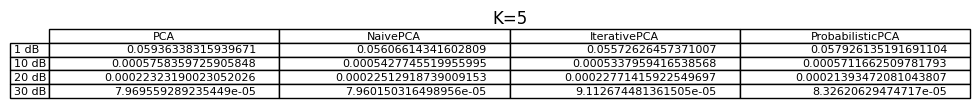

In [19]:
fig, ax = plt.subplots(figsize=(10,1))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
plt.table(cellText=values,
          rowLabels=SNR,
          colLabels=methods,
          loc='center')
fig.tight_layout()
ax.set_title("K="+str(k_values))

## 1.2 PCA with missing data

In [20]:
def missing_data(N, M, missing_percentage, K):
    data_size = N*M
    done = 1
    while done:
        missing_data_size = int(np.fix(missing_percentage*data_size))
        empty_indices  = np.random.permutation(data_size)
        empty_indices  = sorted(empty_indices[:missing_data_size])

        W = np.ones((N,M))
        W.ravel()[empty_indices] = 0
        if np.all(np.sum(W,1)>=K) and np.all(np.sum(W,0)>=1):
            done = 0
    return W

In [21]:
N, M = 1000, 20
w_values = np.linspace(0, 0.3, 10) * 100
W = [missing_data(N, M, i, k_values) for i in w_values/100]

In [23]:
compPCA = [random_comparison(k_values, pca_, SNR=3, W=w) for w in W]
compNaive = [random_comparison(k_values, naive_pca, it=20, SNR=3, W=w) for w in W]
compIterative = [random_comparison(k_values, iterative_pca, it=100, SNR=3, W=w) for w in W]
compPPCA = [random_comparison(k_values, ppca, it=1000, SNR=3, W=w) for w in W]

Used SNR:  10.30625885389861
Used SNR:  10.370000212460623
Used SNR:  10.405594013008082
Used SNR:  10.457363987572574
Used SNR:  10.378092183065712
Used SNR:  10.391180043158801
Used SNR:  10.38507371735307
Used SNR:  10.492228547139813
Used SNR:  10.335966391357855
Used SNR:  10.423036759794641
Used SNR:  10.4358476968987
Used SNR:  10.564088969590575
Used SNR:  10.286316626729086
Used SNR:  10.421373271365201
Used SNR:  10.467891299935193
Used SNR:  10.2739122416513
Used SNR:  10.54511423749238
Used SNR:  10.342903225010549
Used SNR:  10.289882556538386
Used SNR:  10.436293988585277
Used SNR:  10.481787278437793
Used SNR:  10.462824525611445
Used SNR:  10.368912159514
Used SNR:  10.421694538485527
Used SNR:  10.491905805022517
Used SNR:  10.40569080867722
Used SNR:  10.342740739391783
Used SNR:  10.489841766254782
Used SNR:  10.478988247116568
Used SNR:  10.455308511574403
Used SNR:  10.322799787170675
Used SNR:  10.484554823077488
Used SNR:  10.58858457655833
Used SNR:  10.35322488

In [24]:
compPCA, compNaive, compIterative, compPPCA = np.array(compPCA), np.array(compNaive), np.array(compIterative), np.array(compPPCA)

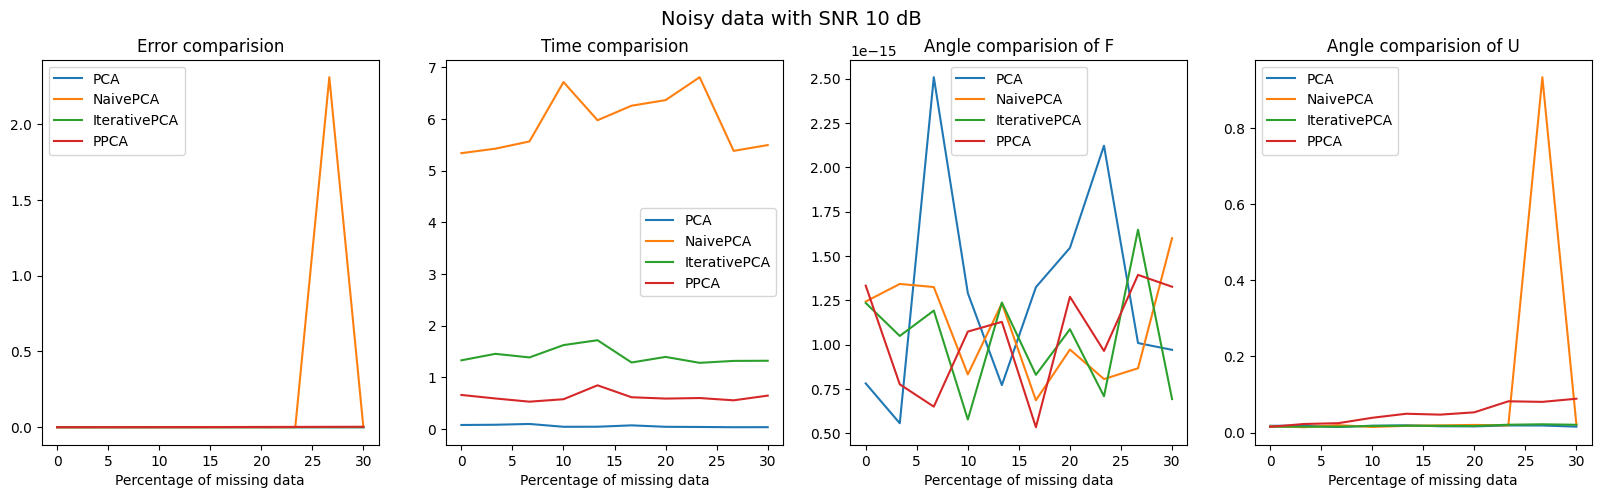

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot(w_values, compPCA[:, 2], label='PCA')
ax[0].plot(w_values, compNaive[:, 2], label='NaivePCA')
ax[0].plot(w_values, compIterative[:,2], label='IterativePCA')
ax[0].plot(w_values, compPPCA[:, 2], label='PPCA')
ax[0].legend()
ax[0].set_xlabel("Percentage of missing data")
ax[0].set_title("Error comparision")
ax[1].plot(w_values, compPCA[:, 3], label='PCA')
ax[1].plot(w_values, compNaive[:, 3], label='NaivePCA')
ax[1].plot(w_values, compIterative[:, 3], label='IterativePCA')
ax[1].plot(w_values, compPPCA[:, 3], label='PPCA')
ax[1].legend()
ax[1].set_xlabel("Percentage of missing data")
ax[1].set_title("Time comparision")
ax[2].plot(w_values, compPCA[:, 0], label='PCA')
ax[2].plot(w_values, compNaive[:, 0], label='NaivePCA')
ax[2].plot(w_values, compIterative[:, 0], label='IterativePCA')
ax[2].plot(w_values, compPPCA[:, 0], label='PPCA')
ax[2].set_xlabel("Percentage of missing data")
ax[2].legend()
ax[2].set_title("Angle comparision of F")
ax[3].plot(w_values, compPCA[:, 1], label='PCA')
ax[3].plot(w_values, compNaive[:, 1], label='NaivePCA')
ax[3].plot(w_values, compIterative[:, 1], label='IterativePCA')
ax[3].plot(w_values, compPPCA[:, 1], label='PPCA')
ax[3].set_xlabel("Percentage of missing data")
ax[3].legend()
ax[3].set_title("Angle comparision of U")
fig = plt.gcf()
fig.suptitle("Noisy data with SNR 10 dB", fontsize=14)
plt.savefig("pcaW1.2_10.png")

## 2. Data analysis with PCA

In [39]:
import scipy.io
mat = scipy.io.loadmat('/home/julia/Documents/SIGMA/Factorization/1_PCA/Programs_Students/DataDecathlon.mat')

In [40]:
X = mat['Data'].copy()
W = np.ones(X.shape)
W[np.isnan(X)] = 0
X[np.isnan(X)] = 0

In [41]:
mat_complete = scipy.io.loadmat('/home/julia/Documents/SIGMA/Factorization/DataDecathlon_Complete.mat')
name_variables = mat_complete['nameVariables'].reshape(-1)
X_complete = mat_complete['Data']

In [53]:
def comparison(X, K, method=pca_, W=None, it=1, X_complete=None):
    "Function to compute PCA from data X"
    if isinstance(K, int):
        mean = X.mean(0)
        X_centered = X - mean
        F, U = method(X.copy(), K, W, it)
        if X_complete is not None:
            error = norm(X_complete - np.matmul(F, U.T) + mean)**2/(M*N)
        else:
            error = norm(X_centered - np.matmul(F, U.T))**2/(M*N)
        return error, F, U
    else:
        _comparison, _F, _U = [], [], []
        for k in K:
            mean = X.mean(0)
            X_centered = X - mean
            F, U = method(X.copy(), k, W, it)
            if X_complete is not None:
                error = norm(X_complete - np.matmul(F, U.T) + mean)**2/(M*N)
            else:
                error = norm(X_centered - np.matmul(F, U.T))**2/(M*N)                
            _comparison += [error]
            _F += [F]
            _U += [U]
        return np.array(_comparison), _F, _U

In [43]:
k_values = np.arange(2, 11)

In [44]:
# PCA compared with X
#compNaive = comparison(X, k_values, method=naive_pca, W=W, it=1000, X_complete=X_completeplete)
compIterative = comparison(X, k_values, method=iterative_pca, W=W, it=1000)
compPPCA = comparison(X, k_values, method=ppca, W=W, it=10000)

In [45]:
# PCA compared with original data
compIterativeC = comparison(X, k_values, method=iterative_pca, W=W, it=1000, X_complete=X_complete)
compPPCAC = comparison(X, k_values, method=ppca, W=W, it=10000, X_complete=X_complete)

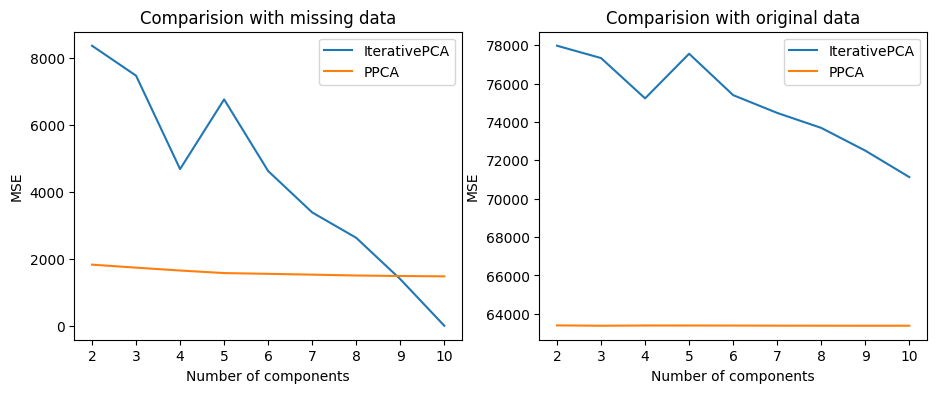

In [46]:
#plt.plot(k_values, compNaive[0], label='NaivePCA')
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(k_values, compIterative[0], label='IterativePCA')
ax[0].plot(k_values, compPPCA[0], label='PPCA')
ax[1].plot(k_values, compIterativeC[0], label='IterativePCA')
ax[1].plot(k_values, compPPCAC[0], label='PPCA')
ax[0].set_xlabel("Number of components")
ax[1].set_xlabel("Number of components")
ax[0].set_ylabel("MSE")
ax[1].set_ylabel("MSE")
ax[0].set_title("Comparision with missing data")
ax[1].set_title("Comparision with original data")
ax[0].legend()
ax[1].legend()
plt.savefig("pcaDecathlon1.png")

In [54]:
from scipy.special import binom
import matplotlib.pyplot as plt
def plot_projection(C, K, selectedIndex=None):
    """
    Function to plot the projection of the observations on the factorial plans computed by PCA.
    
    :param C: NxK array of principal components
    :param K: number of principal components
    :param selectedIndex: list with observations to plot
    """
    if selectedIndex is None:
        selectedIndex = np.arange(C.shape[0])
    ncols = np.ceil(np.sqrt(binom(K,2)) + 1).astype(int)
    nrows = np.ceil(binom(K,2)/ncols).astype(int)
    fig, ax = plt.subplots(nrows, ncols, figsize=(17, 5))
    ax_idx = 0
    axs = ax.flatten()
    for i in range(K):
        for j in range(i+1, K):
            [axs[ax_idx].plot(C[k, i], C[k, j], 'o') for k in selectedIndex]
            [axs[ax_idx].annotate(k, (C[k, i], C[k, j])) for k in selectedIndex]
            axs[ax_idx].set_xlabel('Component ' + str(i+1))
            axs[ax_idx].set_ylabel('Component ' + str(j+1))
            ax_idx +=1
            
def plot_circles(corrcoef, features_names, K):
    """
    Function to plot the correlation circles.
    
    :param corrcoef: array of size MxK with components the Pearson correlation coefficients between the original variables and the principal components.
    :param corrcoef: array of string with the features (variables) names.
    :param K: number of principal components
    """
    ncols = np.ceil(np.sqrt(binom(K,2)) + 1).astype(int)
    nrows = np.ceil(binom(K,2)/ncols).astype(int)
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 5))
    ax_idx = 0
    axs = ax.flatten()
    for i in range(K):
        for j in range(i+1, K): 
            for k in range(len(corrcoef[:, i:j])):
                axs[ax_idx].arrow(0, 0, corrcoef[k, i], corrcoef[k, j], color = 'b', head_width=0.02, head_length=0.02)
                axs[ax_idx].text(corrcoef[k, i]* 1.10, corrcoef[k, j] * 1.10, features_names[k][0], color = 'k', ha = 'center', va = 'center', weight='bold')
            circle = plt.Circle((0, 0), 1, fill=False)
            axs[ax_idx].add_patch(circle)
            axs[ax_idx].plot([-1,1], [0,0], 'k')
            axs[ax_idx].plot([0,0], [-1,1], 'k')
            axs[ax_idx].set_xlim(-1,1)
            axs[ax_idx].set_ylim(-1,1)
            axs[ax_idx].set_xlabel("Component{}".format(i+1))
            axs[ax_idx].set_ylabel("Component{}".format(j+1))
            axs[ax_idx].grid()
            ax_idx += 1

In [48]:
corrcoef = np.empty((X.shape[1], 3))
for k in range(3):
    corrcoef[:, k] = [np.corrcoef([X[:, i], compIterative[1][3][:, k]])[0, 1] for i in range(X.shape[1])]

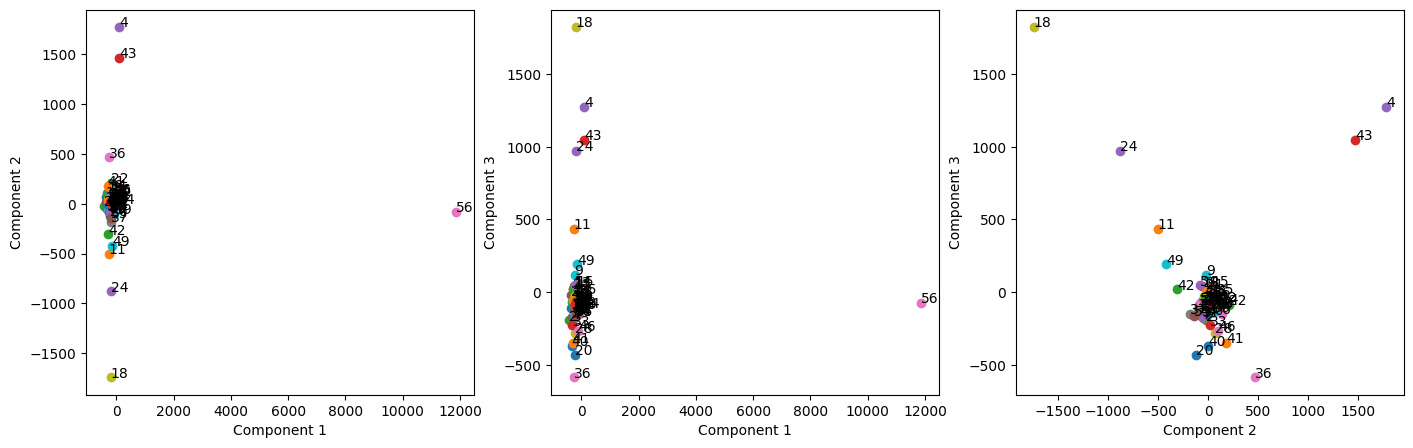

In [56]:
plot_projection(compIterative[1][1], K=3)
plt.savefig("projectionIterative_3.png")

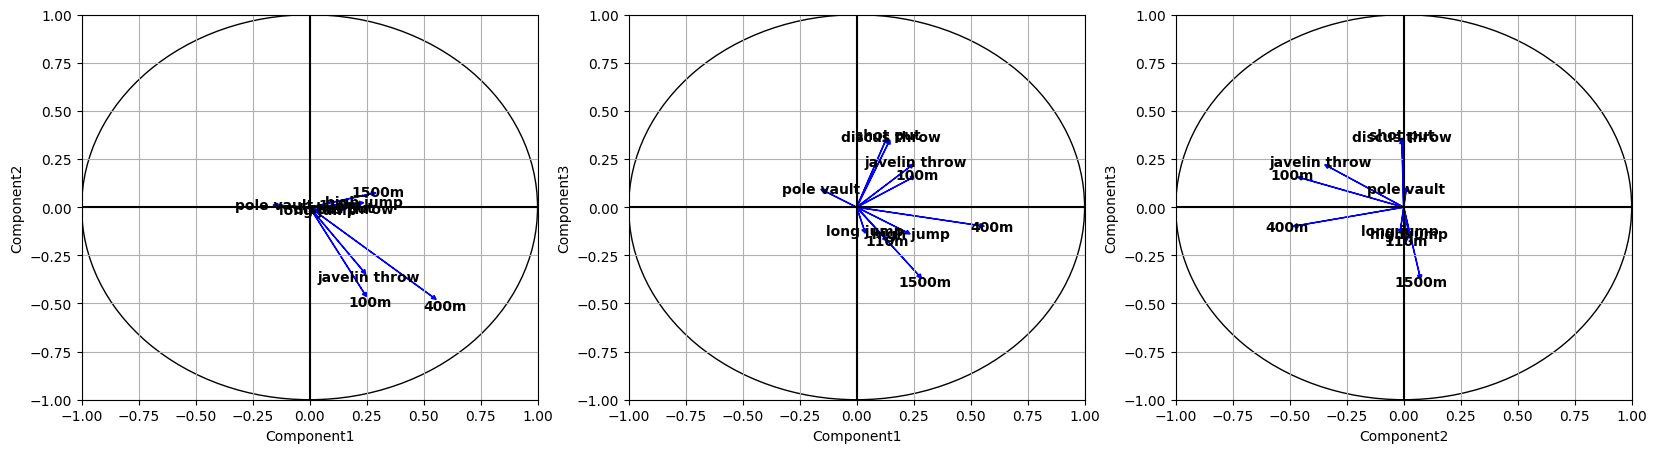

In [52]:
plot_circles(corrcoef, name_variables, 3)
plt.savefig("circlesPPCA.png")